In [ ]:
import numpy as np 
import pandas as pd

from pathlib import Path
WORK_DIR = Path.cwd()
DATA_DIR = Path.cwd()/'data'
OUT_DIR = Path.cwd()/'output'

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

from copy import deepcopy

import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings("ignore")

## Loading Cleaned Data

In [ ]:
train = pd.read_pickle(DATA_DIR/'interim/train.pkl').reset_index(drop=True)
test = pd.read_pickle(DATA_DIR/'interim/test.pkl').reset_index(drop=True)

In [ ]:
array = np.array(train)
np.delete(array, [1,2,3,4,5], 1).shape

In [ ]:
def generate_text_features_col(X, selected_col = 'text'):
    df = X.copy()
    df['length'] = train[selected_col].apply(lambda x: len(x))
    df['word counts'] = train[selected_col].apply(lambda x: len(x.split(' ')))
    df['capital'] = train[selected_col].apply(lambda x: sum(map(str.isupper, x)))
    df['num_hashtags'] = train['hashtags'].apply(lambda x: len(x))
    df['num_tags'] = train[selected_col].apply(lambda x: x.count('@'))

    return df

features_transformer = FunctionTransformer(generate_text_features_col, kw_args={"selected_col": 'text'})
features_transformer.fit_transform(train)
features_transformer.transform(train).head()

In [ ]:
class OHE_Transformer(BaseEstimator, TransformerMixin): 
    def __init__(self, categories=None, col='keyword_processed', to_array=False):
        self.categories = categories
        self.col = col
        self.to_array = to_array
        
    def fit(self, X, y=None):
        self.categories = X.loc[:, self.col].unique()
        return self

    def transform(self, X):
        ohe = pd.get_dummies(X[self.col],drop_first=True)
        ohe = ohe.T.reindex(self.categories).T.fillna(0)
        ohe.columns = ['kw_'+col for col in ohe.columns]
        df = pd.concat([X, ohe], axis=1)

        if self.to_array: 
            df = np.array(df)

        return df

ohe_kw = OHE_Transformer()
ohe_kw.fit_transform(train)
test_transform = ohe_kw.transform(test)

In [ ]:
class Text_Vectorizer(BaseEstimator, TransformerMixin): 
    def __init__(self, col = 'text_processed', tfidf = False, **kwargs):
        self.col = col
        self.tfidf = tfidf
        
        if self.tfidf:
            self.vectorizer = TfidfVectorizer(**kwargs)
        else:
            self.vectorizer = CountVectorizer(**kwargs)
                
    def fit(self, X, y=None):
        self.vectorizer.fit(X[self.col])
        self.vocab = self.vectorizer.get_feature_names()
        return self

    def transform(self, X):
        if self.tfidf:
            vectorizer = TfidfVectorizer(vocabulary = self.vocab)
        else:
            vectorizer = CountVectorizer(vocabulary = self.vocab)
        words = vectorizer.fit_transform(X[self.col]).toarray()
        words_df = pd.DataFrame(words, 
                                columns=['body_'+col for col in vectorizer.get_feature_names()],
                                index=X.index)

        merged = pd.concat([X, words_df], axis=1)
        return merged


In [ ]:
def select_features(X, selected_cols = None, to_array=False):
    df = X.copy()
    if selected_cols is None: 
        selected_cols = df.columns
        
    initial_cols = ['id', 'keyword', 'location', 'text', 'target', 'keyword_processed',
                    'text_processed', 'hashtags']
    select_cols = [col for col in selected_cols if col not in initial_cols]
    df = df[select_cols]
    
    if to_array:
        df = np.array(df)

    return df

feature_selector = FunctionTransformer(select_features, kw_args={"to_array": False})
feature_selector.fit_transform(train)
feature_selector.transform(test_transform)

In [ ]:
class WordVector(BaseEstimator, TransformerMixin): 
    def __init__(self, selected_columns = 'text_processed', spacy_ver = None, num_components=None):
        self.col = selected_columns
        self.spacy = spacy_ver
        self.pca = None 
        self.num_components = num_components 

        if self.spacy is None:
            nlp = spacy.load('en_core_web_sm')
            self.spacy = nlp
                
    def fit(self, X, y=None):
        self.pca = None
        return self

    def transform(self, X):
        text_vector = train['text_processed'].apply(lambda x: nlp(x).vector)
        array = np.array([list(arr) for arr in list(text_vector)])
        
        if self.num_components is not None: 
            if self.pca is not None: 
                pca = self.pca 
                array = pca.transform(array)

            else:
                pca = PCA(n_components=self.num_components)
                array = pca.fit_transform(array)

            self.pca = pca
            self.explained_variance_ratio_ = pca.explained_variance_ratio_
        
        comp_df = pd.DataFrame(array, columns = [f'comp_{i+1}' for i in range(array.shape[1])])
        merged = pd.concat([X, comp_df], axis=1)
        return merged


In [ ]:
nlp = spacy.load('en_core_web_sm')
word_vec = WordVector(spacy_ver = nlp, num_components = 40)

train_vec = word_vec.fit_transform(train)
test_vec = word_vec.transform(test)

In [ ]:
train_vec

#### Building Pipeline

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_vec.drop('target', axis=1), train_vec['target'], test_size=0.2, random_state=123)

In [29]:
pipe = Pipeline([('extra_features', FunctionTransformer(generate_text_features_col, kw_args={"selected_col": 'text'})),
                 ('ohe', OHE_Transformer()), 
                 ('vectorize1', Text_Vectorizer(min_df=40, tfidf = False, ngram_range=(1,1))),
                 ('vectorize2', Text_Vectorizer(min_df=20, tfidf = False, ngram_range=(2,2))),
                 ('feature_selector', FunctionTransformer(select_features, kw_args={"to_array": False})), 
                 ('standard_scaler', StandardScaler())])

In [31]:
shortpipe= deepcopy(pipe)
shortpipe.steps.pop(-1)
shortpipe.fit_transform(X_train)

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,body_natural disaster,body_nuclear reactor,body_oil spill,body_severe thunderstorm,body_suicide bomber,body_suicide bombing,body_thunderstorm warning,body_video http,body_wild fire,body_youtube video
5479,2.124644,0.598725,-0.719797,2.698898,0.004429,1.080855,-0.543080,0.218232,0.102338,-0.539745,...,0,0,0,0,0,0,0,0,0,0
4549,0.732337,-1.296282,-0.273792,1.347489,2.351415,1.198567,0.699633,0.457418,1.425775,0.210745,...,0,0,0,0,0,0,0,0,0,0
3680,-0.737927,0.785732,0.380723,-0.524462,-0.161547,-0.026673,-0.173554,-0.259402,0.126385,-0.159412,...,0,0,0,0,0,0,0,0,0,0
3029,-0.811675,0.204284,1.797013,0.075139,-0.424350,0.752930,-0.035612,-0.134654,0.633392,0.317118,...,0,0,0,0,0,0,0,0,0,0
4385,-1.195578,0.071383,0.286737,-0.227019,0.778967,-1.065972,-0.020321,0.447368,-0.041853,-0.356029,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,0.438595,0.578679,0.059256,-0.204116,-0.189669,-0.404621,-0.256683,-0.028274,0.225497,-0.262714,...,0,0,0,0,0,0,0,0,0,0
4060,2.841407,0.553034,0.389060,-0.460227,-0.265364,0.470694,-0.255650,-0.723730,0.169113,-0.483741,...,0,0,0,0,0,0,0,0,0,0
1346,0.075576,-0.667410,0.711560,0.115935,-0.859448,-0.083471,0.075186,-0.260501,0.292661,-0.168390,...,0,0,0,0,0,0,0,0,0,0
3454,0.161683,-0.422568,0.738339,-0.552854,-0.362145,-0.152133,-0.052407,-0.197139,-0.256396,-0.070369,...,0,0,0,0,0,0,0,0,0,0


## Model Training

In [24]:
lr_pipe = deepcopy(pipe)
lr_pipe.steps.append(['logistic',  LogisticRegression(penalty='l1', solver='liblinear')])
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_test, y_test)

0.7569892473118279

In [25]:
lr_pipe.score(X_train, y_train)

0.8068100358422939

In [41]:
xg_pipe = deepcopy(pipe)
xg_pipe.steps.append(['xgboost',  XGBClassifier(objective='binary:logistic', eval_metric ='error')])
xg_pipe.fit(X_train, y_train)
xg_pipe.score(X_test, y_test)

0.72831541218638

In [42]:
xg_pipe.score(X_train, y_train)

0.9657706093189964

In [34]:
xgb = XGBClassifier(objective='binary:logistic', eval_metric ='error', gamma = 0.1)
xgb.fit(X_train.iloc[:, 8:], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [74]:
xg_pipe = Pipeline([('extra_features', FunctionTransformer(generate_text_features_col, kw_args={"selected_col": 'text'})),
                     ('ohe', OHE_Transformer()), 
                     ('vectorize1', Text_Vectorizer(min_df=40, tfidf = False, ngram_range=(1,1))),
                     ('vectorize2', Text_Vectorizer(min_df=20, tfidf = False, ngram_range=(2,2))),
                     ('feature_selector', FunctionTransformer(select_features, kw_args={"to_array": False})), 
                     ('standard_scaler', StandardScaler())])

In [75]:
xg_params = {"xgboost__learning_rate"    : [0.10, 0.20, 0.30 ] }

In [ ]:
xg_pipe.steps.append(['xgboost',  XGBClassifier(objective='binary:logistic', eval_metric ='error')])
search = GridSearchCV(xg_pipe, xg_params, cv=3, n_jobs=-1, verbose=3)
search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [54]:
search.best_score_

0.6591397849462366

In [106]:
pd.DataFrame(zip(test.id, xg_pipe.predict(test_vec)), columns=['id', 'target']).set_index('id').to_csv(OUT_DIR/'xgboost_2.csv')

ValueError: X has 379 features, but this StandardScaler is expecting 475 features as input.

#### Gridsearch

In [ ]:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}

## Model Evaluation

In [20]:
confusion_matrix(y_test, lr_pipe.predict(X_test), normalize='true')

array([[0.84916865, 0.15083135],
       [0.33815552, 0.66184448]])

#### Shap Values

In [21]:
shortpipe= deepcopy(pipe)
shortpipe.steps.pop(-1)

('standard_scaler', StandardScaler())

In [23]:
import shap

explainer = shap.Explainer(xg_pipe.steps[-1][-1])
shap_values = explainer(shortpipe.fit_transform(X_train))

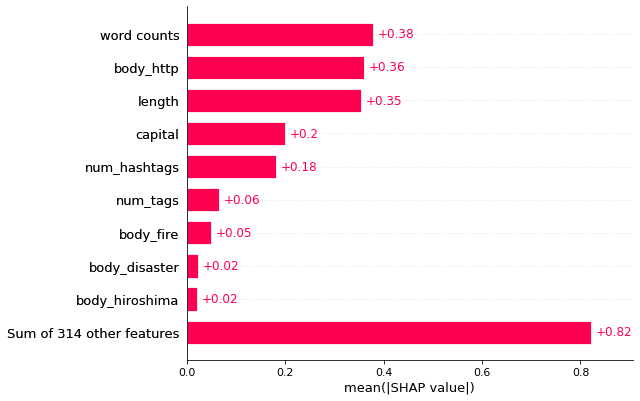

In [24]:
shap.plots.bar(shap_values)